## Binomial Distributions

- Describes the number of successes (x) in 'n' Independent trials.
- Example: Getting exactly 'x' heads in 'n' flips

In Binomial Distribution we will discuss about
1. Finding Flash sale using Binomial PMF
2. Finding Flash sale using Binomial CDF
3. Finding Flash sasle using Z-score Method (MEAN And Variance)
4. Conclusion

### Loading Data sets

In [8]:
#### Load datasets
import pandas as pd
df_dly=pd.read_csv('clean_daily.csv',parse_dates=['date'])
df_dly.info()
df_dly.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 30 entries, 0 to 29
Data columns (total 11 columns):
 #   Column               Non-Null Count  Dtype         
---  ------               --------------  -----         
 0   date                 30 non-null     datetime64[ns]
 1   day_of_week          30 non-null     object        
 2   is_weekend           30 non-null     bool          
 3   is_flash_sale        30 non-null     bool          
 4   visitors             30 non-null     int64         
 5   customers            30 non-null     int64         
 6   conversion_rate      30 non-null     float64       
 7   orders               30 non-null     int64         
 8   orders_per_customer  30 non-null     float64       
 9   aov                  30 non-null     float64       
 10  revenue              30 non-null     float64       
dtypes: bool(2), datetime64[ns](1), float64(4), int64(3), object(1)
memory usage: 2.3+ KB


,date,day_of_week,is_weekend,is_flash_sale,visitors,customers,conversion_rate,orders,orders_per_customer,aov,revenue
0,2023-01-01,Sunday,True,False,1448,52,0.035912,54,1.038462,49.308678,2662.668639
1,2023-01-02,Monday,False,True,595,59,0.099160,145,2.457627,40.367533,5853.292222
2,2023-01-03,Tuesday,False,False,1060,31,0.029245,27,0.870968,52.572194,1419.449243
3,2023-01-04,Wednesday,False,False,946,24,0.025370,26,1.083333,44.823788,1165.418498
4,2023-01-05,Thursday,False,True,1697,148,0.087213,382,2.581081,36.933991,14108.784378


### 1. Finding Flash sale using Binomial PMF

##### Binominal Probability Mass Function:

- Probability of exact value(P(x=k)) or Finding probability of a specific outcome.
- PMF models the probability of having exactly k successes in n independent trials, each with success probability p.

##### Identifying columns for k(desired events),n(no of trials),p(probability of success)

- 'orders' as 'k' : Number of successfull conversions/purchases. 
- 'visitors' as 'n' : Total number of people who visited, each representing a trial where a conversion could happen.
- 'conversion_rate' as 'p': probability that a visitor converts into a customer.

##### Global Conversion Rate 
- Global conversion rate refers to the overall probability (or proportion) of "success" in a population or a dataset.

- In binomial terms, a conversion is considered a "success.

In [70]:
# defining global conversion rate

global_p = df_dly['orders'].sum()/df_dly['visitors'].sum()

#binomial pmf
from scipy.stats import binom

df_dly['pmf'] = df_dly.apply(lambda row: binom.pmf(k=row['orders'],n=row['visitors'],p=global_p),axis=1)

# Very low pmf indicates rare event

df_dly['pmf_flash_flag'] = df_dly['pmf'].apply(lambda p: 'Flash Sale (PMF)' if p<0.01 else 'Normal')



count_normal = (df_dly['pmf_flash_flag'] == 'Normal').sum()
count_flash = (df_dly['pmf_flash_flag'] == 'Flash Sale (PMF)').sum()

print(f'Total Number pmf Flash Sale: {count_flash}')
print(f'Total Number pmf Normal Sale: {count_normal}')

df_dly[['date','visitors','conversion_rate','orders','pmf','pmf_flash_flag']].head()

Total Number pmf Flash Sale: 30
Total Number pmf Normal Sale: 0


,date,visitors,conversion_rate,orders,pmf,pmf_flash_flag
0,2023-01-01,1448,0.035912,54,8.934141e-05,Flash Sale (PMF)
1,2023-01-02,595,0.099160,145,1.089946e-49,Flash Sale (PMF)
2,2023-01-03,1060,0.029245,27,2.118788e-07,Flash Sale (PMF)
3,2023-01-04,946,0.025370,26,4.052865e-06,Flash Sale (PMF)
4,2023-01-05,1697,0.087213,382,5.759603e-116,Flash Sale (PMF)


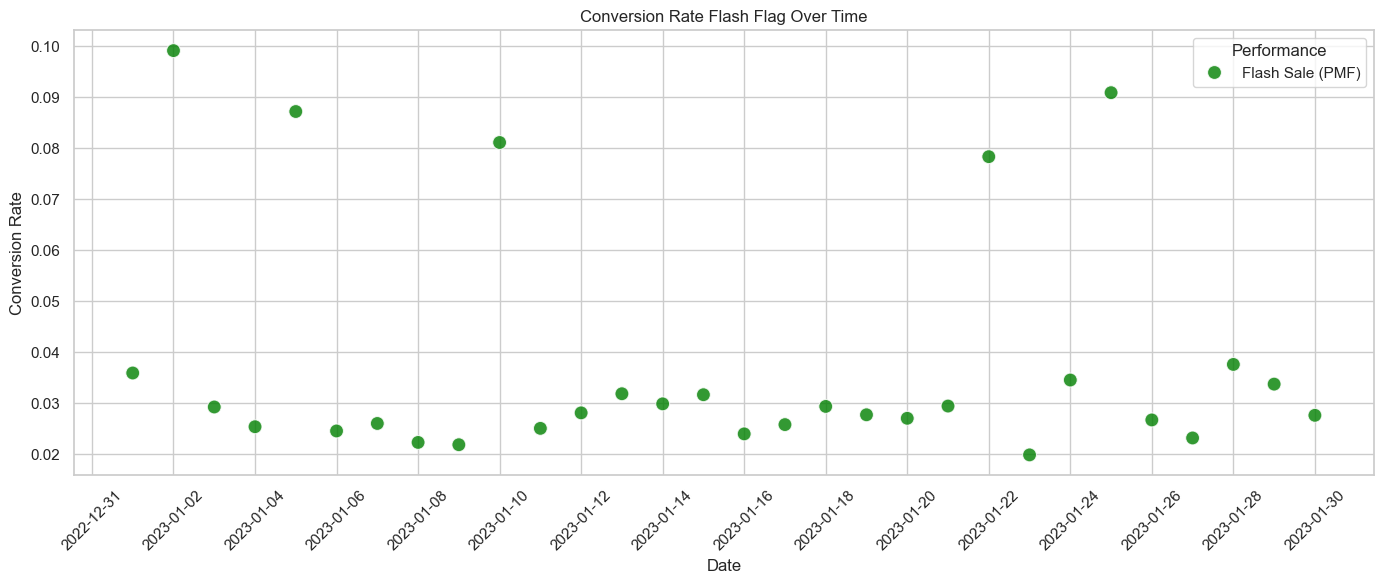

In [29]:
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.dates as mdates

# Ensure 'date' column is in datetime format
df_dly['date'] = pd.to_datetime(df_dly['date'])

# Use seaborn's default styling
sns.set(style="whitegrid")

plt.figure(figsize=(14, 6))

# Color map for performance types
palette = {
    'Not Flash Sale': 'red',
    'Normal': 'gray',
    'Flash Sale (PMF)': 'green'
}

# Scatter plot for performance flag
sns.scatterplot(
    data=df_dly,
    x='date',
    y='conversion_rate',
    hue='pmf_flash_flag',
    palette=palette,
    s=100,
    alpha=0.8
)

plt.title('Conversion Rate Flash Flag Over Time')
plt.xlabel('Date')
plt.ylabel('Conversion Rate')

# Set x-axis ticks every 2 days
plt.gca().xaxis.set_major_locator(mdates.DayLocator(interval=2))
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))

plt.xticks(rotation=45)
plt.legend(title='Performance')
plt.tight_layout()
plt.savefig('performance.png')
plt.show()


#### Observation
- 30 days of flash is unimaginaable , where as Flash sale is open for short period of time, few days or few hours.
- There is not possible to provided heavy discount all 30 days.
- PMF shows distribution of values, not sudden anomalies or spikes.


### 2. Finding Flash sale using Binomial CDF

#####  Binomial Cululatative Distribution Function(CDF)
- Binomial cdf is sum of multiple PMF values up to to 'k' calculated as p(x<=k)

In [68]:
# Calculating p_right_tail for each row:

#p_right_tail=P(X≥k)=1−P(X≤k−1)=1−binom.cdf(k−1,n,p)
#1−P(X≤k−1)=P(X≥k)=P(X=k)+P(X=k+1)+⋯+P(X=n)
df_dly['p_right_tail'] = df_dly.apply(lambda row: 1 - binom.cdf(k=row['orders'] - 1, n=row['visitors'], p=global_p),axis=1)

#Flags days as flash sales if the observed orders are statistically significantly higher than expected (at 5% significance).
df_dly['cdf_flash_flag'] = df_dly['p_right_tail'].apply(lambda p: 'Flash Sale (CDF)' if p < 0.05 else 'Normal')


count_normal = (df_dly['cdf_flash_flag'] == 'Normal').sum()
count_flash = (df_dly['cdf_flash_flag'] == 'Flash Sale (CDF)').sum()

print(f'Total Number pmf Flash Sale: {count_flash}')
print(f'Total Number pmf Normal Sale: {count_normal}')

df_dly[['date','visitors','conversion_rate','orders','p_right_tail','cdf_flash_flag']].head()

Total Number pmf Flash Sale: 5
Total Number pmf Normal Sale: 25


,date,visitors,conversion_rate,orders,p_right_tail,cdf_flash_flag
0,2023-01-01,1448,0.035912,54,0.999859,Normal
1,2023-01-02,595,0.099160,145,0.000000,Flash Sale (CDF)
2,2023-01-03,1060,0.029245,27,1.000000,Normal
3,2023-01-04,946,0.025370,26,0.999997,Normal
4,2023-01-05,1697,0.087213,382,0.000000,Flash Sale (CDF)


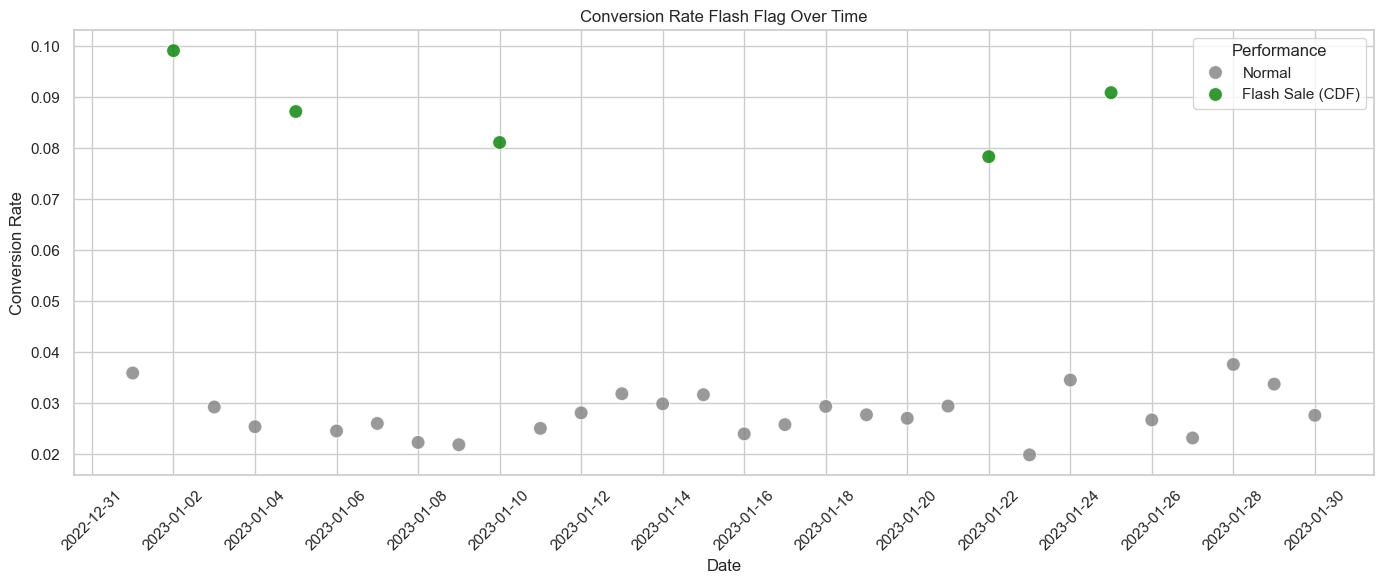

In [51]:
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.dates as mdates

# Ensure 'date' column is in datetime format
df_dly['date'] = pd.to_datetime(df_dly['date'])

# Use seaborn's default styling
sns.set(style="whitegrid")

plt.figure(figsize=(14, 6))

# Color map for performance types
palette = {
    'Not Flash Sale': 'red',
    'Normal': 'gray',
    'Flash Sale (CDF)': 'green'
}

# Scatter plot for performance flag
sns.scatterplot(
    data=df_dly,
    x='date',
    y='conversion_rate',
    hue='cdf_flash_flag',
    palette=palette,
    s=100,
    alpha=0.8
)

plt.title('Conversion Rate Flash Flag Over Time')
plt.xlabel('Date')
plt.ylabel('Conversion Rate')

# Set x-axis ticks every 2 days
plt.gca().xaxis.set_major_locator(mdates.DayLocator(interval=2))
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))

plt.xticks(rotation=45)
plt.legend(title='Performance')
plt.tight_layout()
plt.show()


##### Interpretation

- Scatter plots suggests that at date 2023-01-02,05,10,22,25 Flash sale was opened.
- Y-coordinate higher conversion rate also supports at these date flash sale was offered. 

### 3. Finding Flash sasle using Z-score Method (MEAN And Variance)

In [60]:
import numpy as np

#binomial mean, mu= n.p
df_dly['binom_mean'] = df_dly['visitors'] * global_p

#binomial standard deviatiom, sigma_square = n.p. (1-p)
df_dly['binom_std'] = np.sqrt(df_dly['visitors']* global_p * (1-global_p))

#z-score
df_dly['z_score']=(df_dly['orders']-df_dly['binom_mean'])/ df_dly['binom_std']

# flag flash sale using z-score threshold

df_dly['z_flash_flag'] = df_dly['z_score'].apply(lambda z: 'Flash Sale (z)' if z > 2 else 'Normal')

df_dly[['date','visitors','conversion_rate','orders','binom_mean','binom_std','z_score','z_flash_flag']].head()



,date,visitors,conversion_rate,orders,binom_mean,binom_std,z_score,z_flash_flag
0,2023-01-01,1448,0.035912,54,83.890464,8.889895,-3.362297,Normal
1,2023-01-02,595,0.099160,145,34.471565,5.698635,19.395598,Flash Sale (z)
2,2023-01-03,1060,0.029245,27,61.411528,7.606157,-4.524167,Normal
3,2023-01-04,946,0.025370,26,54.806892,7.185515,-4.009022,Normal
4,2023-01-05,1697,0.087213,382,98.316380,9.623948,29.476844,Flash Sale (z)


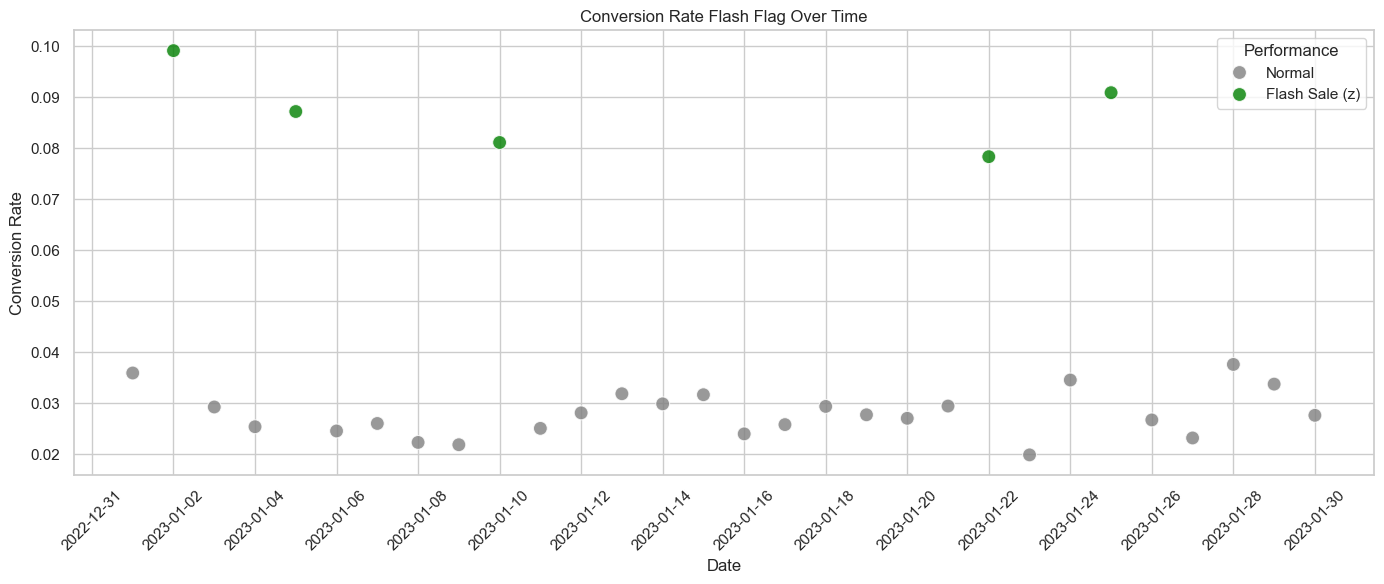

In [62]:

# Ensure 'date' column is in datetime format
df_dly['date'] = pd.to_datetime(df_dly['date'])

# Use seaborn's default styling
sns.set(style="whitegrid")

plt.figure(figsize=(14, 6))

# Color map for performance types
palette = {
    'Not Flash Sale': 'red',
    'Normal': 'gray',
    'Flash Sale (z)': 'green'
}

# Scatter plot for performance flag
sns.scatterplot(
    data=df_dly,
    x='date',
    y='conversion_rate',
    hue='z_flash_flag',
    palette=palette,
    s=100,
    alpha=0.8
)

plt.title('Conversion Rate Flash Flag Over Time')
plt.xlabel('Date')
plt.ylabel('Conversion Rate')

# Set x-axis ticks every 2 days
plt.gca().xaxis.set_major_locator(mdates.DayLocator(interval=2))
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))

plt.xticks(rotation=45)
plt.legend(title='Performance')
plt.tight_layout()
plt.show()


#### Interpretation

- Scatter plots suggests that at date 2023-01-02,05,10,22,25 Flash sale was opened which match with cdf_flash_flag.
- Y-coordinate higher conversion rate also supports at these date flash sale was offered.

4. ### Conclusion

   -  PMF is sensitive to exact k (orders), so nearby values might be misclassified.
   -  CDF works with small or large samples, gives the probability of seeing this many or more orders — which is exactly what a flash sale implies.
   -  Z-scores assume approximate normality — only reliable when n is large (e.g., visitors > 30–50).
   ##### Most statistically valid for determining Flash sale  is Binomial CDF